In [67]:
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)
import Dataloader as _D
reload(_D)

<module 'Dataloader' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\Dataloader.py'>

In [68]:
PORTFOLIO = list(_C.commodities.keys())

In [5]:
PORTFOLIO = ['rb', 'hc', 'i', 'm', 'bu', 'SA']

### Pnl

In [69]:
Pnl = {}
total_d_gain = pd.Series([])
total_d_gain = total_d_gain.reindex(_C.BACKTEST_VTD).fillna(0)

In [40]:
for com in _D.commodities.keys():
    com_balance= pd.read_csv(f'output/balance_sheet/{_C.VERSION}/{com}_balance.csv')
    com_balance = com_balance.set_index(com_balance.columns[0])
    Pnl[com] = com_balance['Pnl']
    if com in PORTFOLIO:
        total_d_gain += com_balance['d_gain']

Pnl['portfolio'] = 1 + total_d_gain.cumsum()/(len(PORTFOLIO) * _C.INIT_CAP)

In [41]:
def draw_pnl(scom):
    fig, axes = plt.subplots(figsize=(10, 5), dpi=80)
    plt.title(f'{scom} Pnl')
    Pnl[scom].plot()

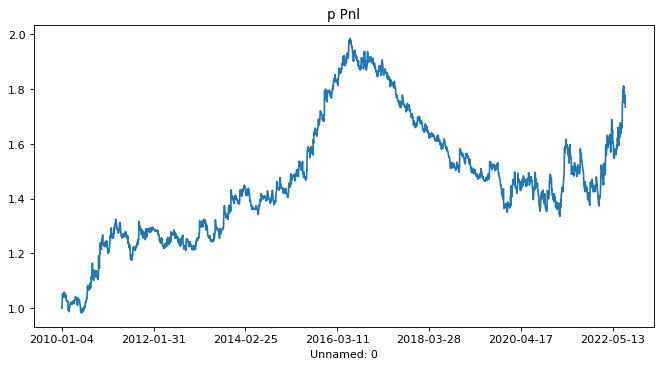

In [42]:
draw_pnl('p')

In [43]:
with open(f'./output/v_analysis/{_C.VERSION}/Pnl.pkl', 'wb') as f:
    pickle.dump(Pnl, f)

In [44]:
def profitable_analysis(_pnl):
    report = pd.DataFrame(columns=['Annual Return', 'Std', 'Sharpe', 'MaxDrawdown', 'Calmar'])
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - list(_pnl)/pd.Series(list(_pnl.rolling(len(_pnl)))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    report.loc[report.shape[0]] = [Annual_r, Std, Sharpe, MaxDrawdown, Calmar]
    return report

In [45]:
profitable_analysis(Pnl['portfolio'])

,Annual Return,Std,Sharpe,MaxDrawdown,Calmar
0,0.056902,0.060602,0.938946,0.060951,0.933563


In [23]:
(1 - list(Pnl['portfolio'])/pd.Series(list(Pnl['portfolio'].rolling(len(Pnl['portfolio'])))).apply(lambda x: x.max())).to_list().index(0.08132254261009442)

2122

In [46]:
_C.BACKTEST_VTD[2122]

'2018-09-21'

### Win-Loss

In [47]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

In [48]:
for com in _C.commodities.keys():
    com_log = np.load(f'output/trading_logs/{_C.VERSION}/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

    if com in PORTFOLIO:
        all_buy = all_buy.append(com_log[0])
        all_sell = all_sell.append(com_log[1])
        all_total = all_total.append(com_log[2])

trading_logs['portfolio'] = [all_buy, all_sell, all_total]

In [49]:
def cal_win_rate(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].shape[0] / _df_['gain'].shape[0], 4)

def cal_win_loss_ratio(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].sum() / _df_['gain'].loc[_df_['gain']<0].sum() * -1, 4)

In [50]:
cols = ['BUY_wr', 'SELL_wr', 'TOTAL_wr', 'BUY_wlr', 'SELL_wlr', 'TOTAL_wlr']
symbols = list(_C.commodities.keys())+['portfolio']

In [51]:
Win_Loss_Analysis = pd.DataFrame(columns=symbols)
WLA = Win_Loss_Analysis.reindex(cols).transpose()

In [52]:
for com in symbols:
    buy_log = trading_logs[com][0]
    sell_log= trading_logs[com][1]
    total_log = trading_logs[com][2]

    WLA['BUY_wr'][com] = cal_win_rate(buy_log)
    WLA['SELL_wr'][com] = cal_win_rate(sell_log)
    WLA['TOTAL_wr'][com] = cal_win_rate(total_log)

    WLA['BUY_wlr'][com] = cal_win_loss_ratio(buy_log)
    WLA['SELL_wlr'][com] = cal_win_loss_ratio(sell_log)
    WLA['TOTAL_wlr'][com] = cal_win_loss_ratio(total_log)

In [53]:
WLA

,BUY_wr,SELL_wr,TOTAL_wr,BUY_wlr,SELL_wlr,TOTAL_wlr
rb,0.3056,0.2957,0.284,1.1269,1.1359,1.0963
hc,0.3207,0.2793,0.301,1.1092,0.9458,1.0421
i,0.309,0.2876,0.2938,1.1194,1.1508,1.162
m,0.3144,0.2879,0.2992,1.1359,1.0356,1.0552
pp,0.2877,0.3032,0.2935,0.8932,1.1054,1.0088
MA,0.2952,0.2693,0.2852,1.0345,0.9612,0.9984
bu,0.2874,0.3025,0.2971,1.0467,1.0653,1.1156
l,0.3013,0.28,0.288,0.9625,1.0095,0.9789
p,0.3028,0.2699,0.2908,1.1314,1.0205,1.1019
v,0.2826,0.2766,0.2843,1.0156,1.0292,1.0735


In [56]:
WLA.to_csv(f'./output/v_analysis/{_C.VERSION}/Win-Loss.csv')

In [21]:
cc = pd.read_csv('./output/version/v1/Win-Loss.csv', index_col=0)

### Positions

#### Positions Holding Time

In [57]:
hold_t = {}
all_hold_t = []
all_hold_t = pd.Series(all_hold_t)

for com in _C.commodities.keys():
    _df = trading_logs[com][2].copy(deep=True)

    delta_t = pd.to_datetime(_df['close_date']) - pd.to_datetime(_df['open_date'])
    _df['hold_t'] = (delta_t).apply(lambda x: x.total_seconds()/60)

    hold_t[com] = _df['hold_t']
    if com in PORTFOLIO:
        all_hold_t = all_hold_t.append(_df['hold_t'])

hold_t['portfolio'] = all_hold_t

In [58]:
def hold_t_analysis(scom):
    ht = hold_t[scom]
    print(ht.describe())
    ht.hist(bins=20)

In [59]:
cols_2 = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
HTA = pd.DataFrame(columns=symbols)
HTA = HTA.reindex(cols_2).transpose()

In [60]:
for com in symbols:
    ht = hold_t[com]
    des = list(ht.describe())
    for i in cols_2:
        HTA[i][com] = round(int(des[cols_2.index(i)])/60, 1) if cols_2.index(i)>0 else des[cols_2.index(i)]

In [61]:
HTA # Holding Period Time

,count,mean,std,min,25%,50%,75%,max
rb,2109,25.6,46.7,0,0,0,24,456
hc,1761,19,38.8,0,0,0,24,504
i,1535,23.1,42.9,0,0,0,24,408
m,2263,25.7,48.2,0,0,0,24,600
pp,1455,25.2,46,0,0,0,24,360
MA,1697,20,38.2,0,0,0,24,384
bu,1774,23.4,44.5,0,0,0,24,504
l,1875,29,54,0,0,0,24,528
p,2431,22.5,43,0,0,0,24,504
v,2075,27.4,50.5,0,0,0,24,624


In [62]:
HTA.to_csv(f'./output/v_analysis/{_C.VERSION}HTA.csv')

#### Daily Trade Num

In [63]:
trade_num = {}
all_trade_num = pd.Series([0 for i in range(len(_C.BACKTEST_VTD))])

for com in _C.commodities.keys():
    tn = [0 for i in range(len(_C.BACKTEST_VTD))]
    com_log = trading_logs[com]
    _df = com_log[2].copy(deep=True)

    for i in range(_df.shape[0]):
        entry = _df.iloc[i]
        tn[_C.BACKTEST_VTD.index(entry['open_date'])] += 1
        tn[_C.BACKTEST_VTD.index(entry['close_date'])] += 1
    
    trade_num[com] = tn
    if com in PORTFOLIO:
        all_trade_num += pd.Series(tn)

trade_num['portfolio'] = all_trade_num.to_list()

ValueError: '2022-06-27' is not in list

In [111]:
DTN = pd.DataFrame()
DTN = DTN.reindex(_C.BACKTEST_VTD)

for com in symbols:
    DTN[com] = trade_num[com]

In [112]:
DTN # Daily Trade Num

,rb,hc,i,m,pp,MA,bu,l,p,v,CF,OI,SR,TA,SA,portfolio
2010-01-04,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2010-01-05,1,0,0,0,0,0,0,0,0,3,1,0,4,2,0,1
2010-01-06,3,0,0,0,0,0,0,4,0,3,1,0,3,0,0,3
2010-01-07,3,0,0,1,0,0,0,4,1,2,2,0,3,2,0,4
2010-01-08,3,0,0,1,0,0,0,0,1,2,4,0,3,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-20,1,0,2,2,0,2,1,2,1,0,3,2,2,6,4,10
2022-06-21,3,1,1,4,4,1,2,1,0,2,0,0,2,3,0,11
2022-06-22,4,2,0,5,3,2,3,0,1,3,1,0,3,5,2,16
2022-06-23,1,1,1,1,4,2,3,0,0,3,1,1,0,4,1,8


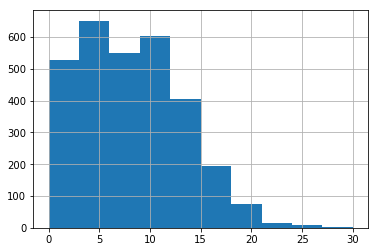

In [114]:
DTN['portfolio'].hist()

In [115]:
DTN.to_csv('./output/version/v1/DTN.csv')

### Version Comparation

In [35]:
Pnl.keys()

dict_keys(['rb', 'hc', 'i', 'm', 'pp', 'MA', 'bu', 'l', 'p', 'v', 'CF', 'OI', 'SR', 'TA', 'SA', 'total'])

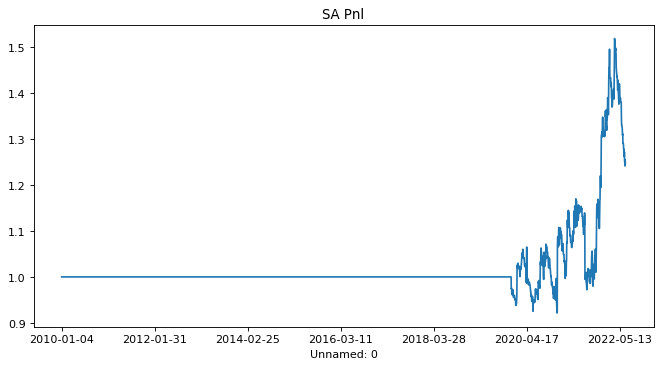

In [50]:
draw_pnl('SA')